<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Parsing SEC EDGAR XBRL data



# SEC's EDGAR
<hr style="border:2px solid black"> </hr>


- The Securities and Exchange Commission (SEC) requires US issuers, that is, listed companies and securities, including mutual funds to file three quarterly financial statements (Form 10-Q) and one annual report (Form 10-K), in addition to various other regulatory filing requirements.

- Since the early 1990s, the SEC made these filings available through its Electronic Data Gathering, Analysis, and Retrieval (**EDGAR**) system. They constitute the primary data source for the fundamental analysis of equity and other securities, such as corporate credit, where the value depends on the business prospects and financial health of the issuer.

- SEC introduced XBRL, a free, open, and global standard for the electronic representation and exchange of business reports. XBRL is based on XML; it relies on taxonomies that define the meaning of the elements of a report and map to tags that highlight the corresponding information in the electronic version of the report. One such taxonomy represents the US Generally Accepted Accounting Principles (GAAP).



# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
from tqdm import tqdm
import requests

import pandas_datareader.data as web
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [3]:
sns.set_style('whitegrid')

# Donwload data
<hr style="border:2px solid black"> </hr>

In [4]:
# store data in this directory since we won't use it in other chapters
data_path = Path('./data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

The following code downloads and extracts all historical filings contained in the [Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) datasets from Q1/2014 through Q3/2020. 

> The SEC has moved to a monthly cadence after Q3/2020; feel free to extend the code by creating the correpsonding file names (see linked website) and download those as well.

**Downloads over 40GB of data!**

In [5]:
SEC_URL = 'https://www.sec.gov/'
FSN_PATH = 'files/dera/data/financial-statement-and-notes-data-sets/'

In [6]:
filing_periods = [(d.year, d.quarter) for d in pd.date_range('2014', '2015-09-30', freq='Q')]
filing_periods

[(2014, 1), (2014, 2), (2014, 3), (2014, 4), (2015, 1), (2015, 2), (2015, 3)]

In [7]:
for yr, qtr in tqdm(filing_periods):
    # set (and create) directory
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(parents=True)
    
    # define url and get file
    filing = f'{yr}q{qtr}_notes.zip'
    url = SEC_URL + FSN_PATH + filing
    response = requests.get(url).content
    
    # decompress and save
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        print(f'\nBad zip file: {yr} {qtr}\n')
        continue

100%|██████████████████████████████████████████████████████████████████| 7/7 [09:40<00:00, 82.97s/it]


In [8]:
# Check size of the downloaded data
!du -h data

3.3G	data/2015_1/source
3.3G	data/2015_1
2.4G	data/2014_2/source
2.4G	data/2014_2
2.3G	data/2014_3/source
2.3G	data/2014_3
2.3G	data/2014_4/source
2.3G	data/2014_4
2.3G	data/2015_2/source
2.3G	data/2015_2
2.2G	data/2015_3/source
2.2G	data/2015_3
3.3G	data/2014_1/source
3.3G	data/2014_1
 18G	data


## Save to parquet

The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):

> Some fo the `txt.tsv` source files contain a small number of faulty lines; the code below drops those lines but indicates the line numbers where you can find the errors if you would like to investigate further. 

In [9]:
for f in tqdm(sorted(list(data_path.glob('**/*.tsv')))):
    # set (and create) directory
    parquet_path = f.parent.parent / 'parquet'
    if not parquet_path.exists():
        parquet_path.mkdir(parents=True)    

    # write content to .parquet
    file_name = f.stem  + '.parquet'
    if not (parquet_path / file_name).exists():
        try:
            df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False, error_bad_lines=False)
            df.to_parquet(parquet_path / file_name)
        except Exception as e:
            print(e, ' | ', f)
        # optional: uncomment to delete original .tsv
#         else:
            # f.unlink

100%|████████████████████████████████████████████████████████████████| 56/56 [05:27<00:00,  5.84s/it]


## Metadata json

In [10]:
data_path

PosixPath('data')

In [11]:
file = data_path / '2014_3' / 'source' / '2014q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

                                                            'than 1 are not '
                                                            'needed. The '
                                                            'priority for the '
                                                            'fact based on '
                                                            'higher precision, '
                                                            'closeness of the '
                                                            'end date to a '
                                                            'month end, and '
                                                            'closeness of the '
                                                            'duration to a '
                                                            'multiple of three '
                                                            'months. See '
                                                            '

## Data Organization

For each quarter, the FSN data is organized into eight file sets that contain information about submissions, numbers, taxonomy tags, presentation, and more. Each dataset consists of rows and fields and is provided as a tab-delimited text file:

| File | Dataset      | Description                                                 |
|------|--------------|-------------------------------------------------------------|
| SUB  | Submission   | Identifies each XBRL submission by company, form, date, etc |
| TAG  | Tag          | Defines and explains each taxonomy tag                      |
| DIM  | Dimension    | Adds detail to numeric and plain text data                  |
| NUM  | Numeric      | One row for each distinct data point in filing              |
| TXT  | Plain Text   | Contains all non-numeric XBRL fields                        |
| REN  | Rendering    | Information for rendering on SEC website                    |
| PRE  | Presentation | Detail on tag and number presentation in primary statements |
| CAL  | Calculation  | Shows arithmetic relationships among tags                   |

## Submission Data

The latest submission file contains around 6,500 entries.

In [12]:
sub = pd.read_parquet(data_path / '2014_3' / 'parquet' / 'sub.parquet')
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7790 entries, 0 to 7789
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         7790 non-null   object 
 1   cik          7790 non-null   int64  
 2   name         7790 non-null   object 
 3   sic          7788 non-null   float64
 4   countryba    7764 non-null   object 
 5   stprba       7270 non-null   object 
 6   cityba       7767 non-null   object 
 7   zipba        7758 non-null   object 
 8   bas1         7766 non-null   object 
 9   bas2         3421 non-null   object 
 10  baph         7758 non-null   object 
 11  countryma    7688 non-null   object 
 12  stprma       7226 non-null   object 
 13  cityma       7690 non-null   object 
 14  zipma        7685 non-null   object 
 15  mas1         7688 non-null   object 
 16  mas2         3359 non-null   object 
 17  countryinc   7100 non-null   object 
 18  stprinc      6923 non-null   object 
 19  ein   

### Get AAPL submission

The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Apple's 2018Q1 10-Q filing:

In [13]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

name                    APPLE INC
adsh         0001193125-14-277160
cik                        320193
name                    APPLE INC
sic                        3571.0
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1            ONE INFINITE LOOP
form                         10-Q
period                   20140630
fy                         2014.0
fp                             Q3
filed                    20140723
Name: 582, dtype: object

## Build AAPL fundamentals dataset

Using the central index key, we can identify all historical quarterly filings available for Apple, and combine this information to obtain 26 Forms 10-Q and nine annual Forms 10-K.

### Get filings

In [14]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

We find 15 quarterly 10-Q and 4 annual 10-K reports:

In [15]:
aapl_subs.form.value_counts()

10-Q    6
10-K    1
Name: form, dtype: int64

### Get numerical filing data

With the Accession Number for each filing, we can now rely on the taxonomies to select the appropriate XBRL tags (listed in the TAG file) from the NUM and TXT files to obtain the numerical or textual/footnote data points of interest.

First, let's extract all numerical data available from the 19 Apple filings:

In [16]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')

751
805
919
1271
942
961
682


In total, the nine years of filing history provide us with over 18,000 numerical values for AAPL.

In [17]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6331 entries, 4298 to 7985586
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   adsh      6331 non-null   object        
 1   tag       6331 non-null   object        
 2   version   6331 non-null   object        
 3   ddate     6331 non-null   datetime64[ns]
 4   qtrs      6331 non-null   int64         
 5   uom       6331 non-null   object        
 6   iprx      6331 non-null   int64         
 7   value     6309 non-null   float64       
 8   footnote  48 non-null     object        
 9   footlen   6331 non-null   int64         
 10  dimn      6331 non-null   int64         
 11  coreg     0 non-null      object        
 12  durp      6331 non-null   float64       
 13  datp      6331 non-null   float64       
 14  dcml      6331 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 791.4+ KB


## Create P/E Ratio from EPS and stock price data

We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.

In [18]:
stock_split = 7
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

We do need to take into account, however, that Apple split its stock 7:1 on June 4, 2014, and Adjusted Earnings per Share before the split to make earnings comparable, as illustrated in the following code block:

In [19]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earnings prior to stock split downward
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()

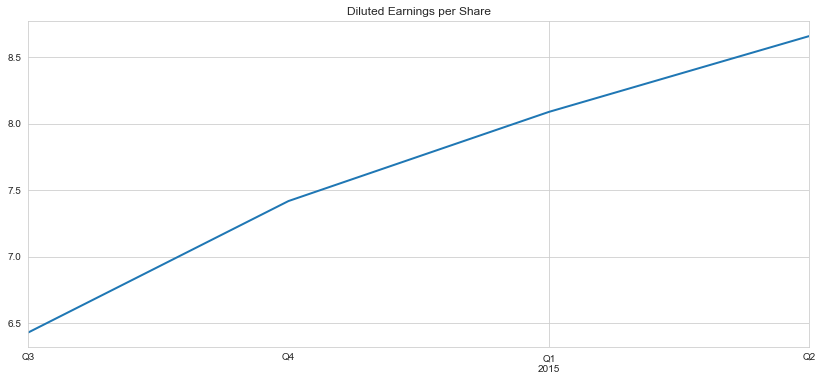

In [20]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')

In [22]:
symbol

'AAPL.US'

In [21]:
symbol = 'AAPL.US'

aapl_stock = (web.
              DataReader(symbol, 'quandl', start=eps.index.min())
              .resample('D')
              .last()
             .loc['2014':eps.index.max()])
aapl_stock.info()

ValueError: The Quandl API key must be provided either through the api_key variable or through the environmental variable QUANDL_API_KEY.

In [ ]:
pe = aapl_stock.AdjClose.to_frame('price').join(eps.to_frame('eps'))
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [ ]:
pe.info()

In [ ]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

## Explore Additional Fields

The field `tag` references values defined in the taxonomy:

In [23]:
aapl_nums.tag.value_counts()

CashAndCashEquivalentsAtCarryingValue                             210
AvailableForSaleSecurities                                        196
AvailableForSaleSecuritiesAmortizedCost                           196
AvailableForSaleSecuritiesCurrent                                 196
AvailableForSaleSecuritiesNoncurrent                              196
                                                                 ... 
FiniteLivedIntangibleAssetsAmortizationExpenseYearFour              1
FiniteLivedIntangibleAssetsAmortizationExpenseYearFive              1
FiniteLivedIntangibleAssetsAmortizationExpenseNextTwelveMonths      1
FiniteLivedIntangibleAssetsAmortizationExpenseAfterYearFive         1
StockIssuedDuringPeriodSharesAcquisitions                           1
Name: tag, Length: 357, dtype: int64

We can select values of interest and track their value or use them as inputs to compute fundamental metrics like the Dividend/Share ratio.

### Dividends per Share

In [24]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

IndexError: index 0 is out of bounds for axis 0 with size 0

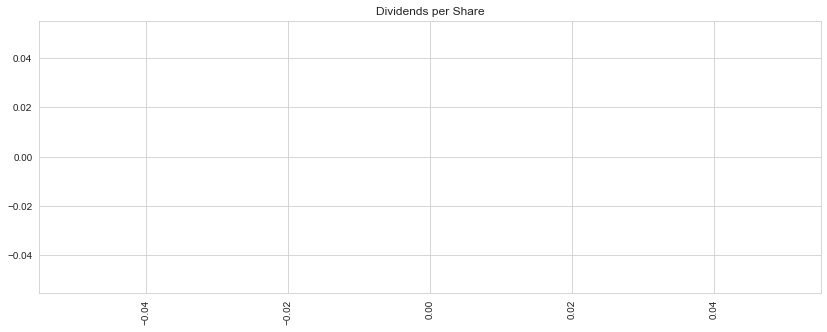

In [25]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

## Bonus: Textual Information

In [ ]:
txt = pd.read_parquet(data_path / '2016_2' / 'parquet' /  'txt.parquet')

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statements here:

In [ ]:
txt.head()

# Clean-up folder
<hr style="border:2px solid black"> </hr>

In [26]:
!rm -rf ./data

# References
<hr style="border:2px solid black"> </hr>


- [How to work with Fundamental data](https://github.com/stefan-jansen/machine-learning-for-trading/tree/main/02_market_and_fundamental_data/04_sec_edgar)

